In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rom_tools import rom_manager
from rom_tools.address import *
from rom_tools import byte_ops
from rom_tools.compress import decompress

In [3]:
from PIL import Image
from PIL import ImageOps

In [4]:
rom_m = rom_manager.RomManager("../sm_guinea_pig.smc", "../sm_newlevel.smc")

## Palette

In [5]:
# ucp - Upper Crateria Palette
ucp_addr = Address(0xc2ad7c, mode="snes")
ucp_addr

0x212d7c

In [6]:
compressed_ucp = rom_m.read_from_clean(ucp_addr, 1000)
ucp = decompress.decompress(compressed_ucp)
len(ucp)

256

In [7]:
# 15 bit BGR, highest bit unused
def get_rgb(color):
    r_mask = 0b11111
    g_mask = r_mask << 5
    b_mask = r_mask << 10
    # Mask out the correct 5-bit values
    r5 = color & r_mask
    g5 = (color & g_mask) >> 5
    b5 = (color & b_mask) >> 10
    # Upscale them to 8-bit
    r8 = r5 << 3
    g8 = g5 << 3
    b8 = b5 << 3
    return (r8, g8, b8)
    

In [8]:
i = int.from_bytes(ucp[8:10], byteorder='little')
get_rgb(i)

(168, 120, 184)

In [9]:
palette_bytes = rom_m.read_compressed_list(ucp_addr, 2, 128)
palette_colors = list(map(lambda x: get_rgb(int.from_bytes(x, byteorder='little')), palette_bytes))

In [10]:
palette = Image.new("RGBA", (16,8), "black")
for x in range(16):
    for y in range(8):
        index = y * 16 + x
        r,g,b = palette_colors[index]
        if x == 0:
            a = 0
        else:
            a = 255
        palette.putpixel((x,y), (r,g,b,a))
palette.save("palette.png")

## Subtile Sheet

In [2]:
uc_subtile_addr = Address(0xbac629, mode="snes")
uc_subtile_addr

NameError: name 'Address' is not defined

In [12]:
compressed_uc_subtiles = rom_m.read_from_clean(uc_subtile_addr, 16000)
uc_subtiles = decompress.decompress(compressed_uc_subtiles)
len(uc_subtiles) / 32

576.0

In [13]:
uc_subtiles_bytes = rom_m.read_compressed_list(uc_subtile_addr, 32, 576)

In [14]:
def get_pixel_color_index(tile, x, y, bpp=4):
    palette_index = 0
    for i in range(bpp // 2):
        for j in range(2):
            palette_index |= (tile[y * 2 + i * 0x10 + j] >> 7 - x & 1) << i * 2 + j
    return palette_index

In [15]:
def build_subtile(subtile_bytes, palette, palette_index_y):
    subtile = Image.new("RGBA", (8,8), "black")
    for x in range(8):
        for y in range(8):
            palette_index_x = get_pixel_color_index(subtile_bytes, x, y)
            palette_color = palette.getpixel((palette_index_x, palette_index_y))
            subtile.putpixel((x, y), palette_color)
    return subtile

# Arrange a list of images into one big image
def tiled_image(images, width, height):
    assert width * height == len(images)
    i = images[0]
    i_width = i.width
    i_height = i.height
    out = Image.new("RGBA", (width * i_width, height * i_height), "black")
    for index, image in enumerate(images):
        x = index % width
        y = index // width
        out.paste(image, (x * i_width, y * i_height))
    return out

def save_subtile_image(filename, subtiles, width, height, palette_y=0):
    subtile_images = [build_subtile(x, palette, palette_y) for x in subtiles]
    subtile_image = tiled_image(subtile_images, width, height)
    subtile_image.save(filename)

In [16]:
save_subtile_image("uc_subtiles.png", uc_subtiles_bytes, 16, 36)

## CRE

In [17]:
cre_tile_snes = Address(0xb98000, mode="snes")
cre_tile_addr

0x1c8000

In [18]:
compressed_cre_subtiles = rom_m.read_from_clean(cre_tile_addr, 10000)
cre_subtiles = decompress.decompress(compressed_cre_subtiles)
len(cre_subtiles) / 32
# 384 cre subtiles

384.0

In [19]:
cre_subtiles_bytes = rom_m.read_compressed_list(cre_tile_addr, 32, 384)

In [20]:
save_subtile_image("cre_subtiles.png", cre_subtiles_bytes, 16, 24)

## Tile Table

In [21]:
# PJBoy said that the tilesheet is 0x280 tilesheet-specific tiles followed by 0x180 CRE tiles for a total of
# 0x400 = 1024 tiles
# SCE uses 0x280 tiles before starting to overwrite the CRE, but isn't required to use all of them
def get_tile_bytes(index, sce_tilesheet, cre_tilesheet):
    # Index is 10 bytes
    assert index >= 0 and index < 0x400, hex(index)
    # SCE takes priority over CRE since it is copied on top of the CRE if it is larger than the normal 0x280 bytes
    if index < len(sce_tilesheet):
        return sce_tilesheet[index]
    # Otherwise it can index into the CRE which is always at 0x280 and above
    elif index >= 0x280:
        return cre_tilesheet[index - 0x280]
    # Something is going wrong if it is indexing a value between the end of the SCE and before the
    # beginning of the CRE
    else:
        assert False, hex(index)
        
def apply_flips(image, flips):
    # y
    if flips[0]:
        image = ImageOps.flip(image)
    # x
    if flips[1]:
        image = ImageOps.mirror(image)
    return image

# Two bytes
# YXLP PPTT TTTT TTTT    
def get_subtile_def(subtile_bytes):
    q = int.from_bytes(subtile_bytes, byteorder='little')
    y_flip = (q >> 15) & 0b1
    x_flip = (q >> 14) & 0b1
    layer_priority = (q >> 13) & 0b1
    palette_index_y = (q >> 10) & 0b111
    tile_index = q & 0b0000001111111111
    return (y_flip, x_flip, layer_priority, palette_index_y, tile_index)

def get_subtile_image(subtile_def, sce_tilesheet, cre_tilesheet, palette):
    #print(subtile_def)
    y_flip, x_flip, layer_priority, palette_index_y, tile_index = subtile_def
    tile_bytes = get_tile_bytes(tile_index, sce_tilesheet, cre_tilesheet)
    subtile_image = build_subtile(tile_bytes, palette, palette_index_y)
    subtile_image = apply_flips(subtile_image, (y_flip, x_flip))
    return subtile_image
    
def get_tile_image(tile_bytes, sce_tilesheet, cre_tilesheet, palette):
    assert len(tile_bytes) == 8
    subtile_defs = [tile_bytes[i:i+2] for i in range(0,8,2)]
    #print(subtile_defs)
    subtile_images = list(map(lambda x: get_subtile_image(get_subtile_def(x),
                                                    sce_tilesheet, cre_tilesheet, palette), subtile_defs))
    tile_image = tiled_image(subtile_images, 2, 2)
    return tile_image

def save_tile_table_image(filename, tile_table, width, height, sce_subtiles, cre_subtiles, palette):
    tile_images = [get_tile_image(i, sce_subtiles, cre_subtiles, palette) for i in tile_table]
    # No, the irony in this naming scheme is not lost on me
    out = tiled_image(tile_images, width, height)
    out.save(filename)
    
def tile_images(tile_table, sce_subtiles, cre_subtiles, palette):
    return [get_tile_image(i, sce_subtiles, cre_subtiles, palette) for i in tile_table]


In [22]:
cre_tile_table_snes = 0xb9a09d
cre_tile_table_addr = Address(0)
cre_tile_table_addr.from_snes(cre_tile_table_snes)

In [23]:
compressed_cre_tile_table = rom_m.read_from_clean(cre_tile_table_addr, 6000)
cre_tile_table = decompress.decompress(compressed_cre_tile_table)
len(cre_tile_table) / 8
# 256 tiles of CRE

256.0

In [24]:
cre_tile_table_bytes = rom_m.read_compressed_list(cre_tile_table_addr, 8, 256)

In [25]:
save_tile_table_image("cre_tile_table.png", cre_tile_table_bytes, 32, 8, uc_subtiles_bytes, cre_subtiles_bytes, palette)

In [26]:
uc_tile_table_snes = 0xc1b6f6
uc_tile_table_addr = Address(0)
uc_tile_table_addr.from_snes(uc_tile_table_snes)

In [27]:
compressed_uc_tile_table = rom_m.read_from_clean(uc_tile_table_addr, 6000)
uc_tile_table = decompress.decompress(compressed_uc_tile_table)
len(uc_tile_table) / 8
# 768 tiles of SCE for a total of 1024 tiles (10 bits of address space in the level datas)

768.0

In [28]:
uc_tile_table_bytes = rom_m.read_compressed_list(uc_tile_table_addr, 8, 768)

In [29]:
save_tile_table_image("sce_tile_table.png", uc_tile_table_bytes, 32, 24, uc_subtiles_bytes, cre_subtiles_bytes, palette)

## Level Data

In [30]:
# Now we will display room 0x792b3 with our newfound abilities
room_header_addr = Address(0x792b3)
room_header = rom_m.read_from_clean(room_header_addr, 74)

In [31]:
# Find the level data
leveldata_ptr_b = room_header[18:21]
leveldata_ptr_snes = int.from_bytes(leveldata_ptr_b, byteorder='little')
leveldata_addr = Address(0)
leveldata_addr.from_snes(leveldata_ptr_snes)

In [32]:
compressed_level_data = rom_m.read_from_clean(leveldata_addr, 2000)
level_data = decompress.decompress(compressed_level_data)
len(level_data)

3842

In [33]:
from world_rando import room_gen
from world_rando import room_viz
from world_rando.coord import *

In [34]:
level = room_gen.level_from_bytes(level_data, Coord(80,16))

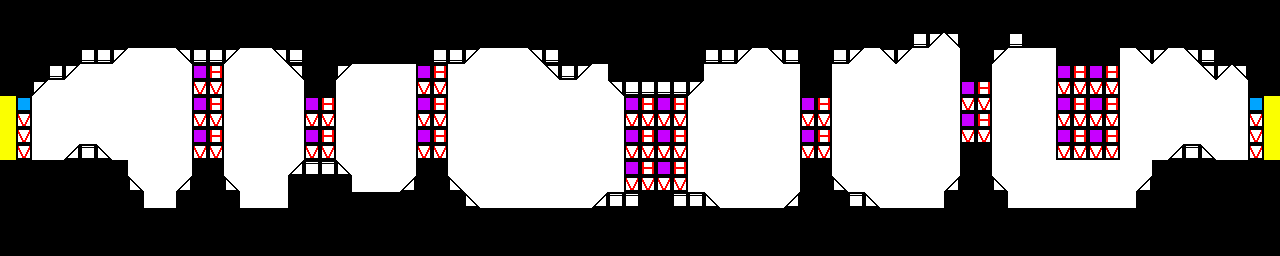

In [35]:
room_viz.room_viz(level, "test.png", "encoding/room_tiles")

In [36]:
def get_tile(index, sce_tile_table, cre_tile_table):
    # Index is 10 bytes
    assert index >= 0 and index < 0x400, hex(index)
    # Index into the CRE
    if index < 0x100:
        return cre_tile_table[index]
    else:
        return sce_tile_table[index - 0x100]
    
def level_image(filename, level, sce_tile_table_images, cre_tile_table_images):
    l_image = Image.new("RGBA", (level.dimensions.x * 16, level.dimensions.y * 16), "white")
    for c in level.itercoords():
        tile = level[c]
        tile_image = get_tile(tile.texture.index, sce_tile_table_images, cre_tile_table_images)
        tile_image = apply_flips(tile_image, tile.texture.flips)
        # Third argument is the alpha mask
        l_image.paste(tile_image, (c.x * 16, c.y * 16), tile_image)
    l_image.save(filename)
    return l_image
    

In [37]:
sce_tiles = tile_images(uc_tile_table_bytes, uc_subtiles_bytes, cre_subtiles_bytes, palette)
cre_tiles = tile_images(cre_tile_table_bytes, uc_subtiles_bytes, cre_subtiles_bytes, palette)

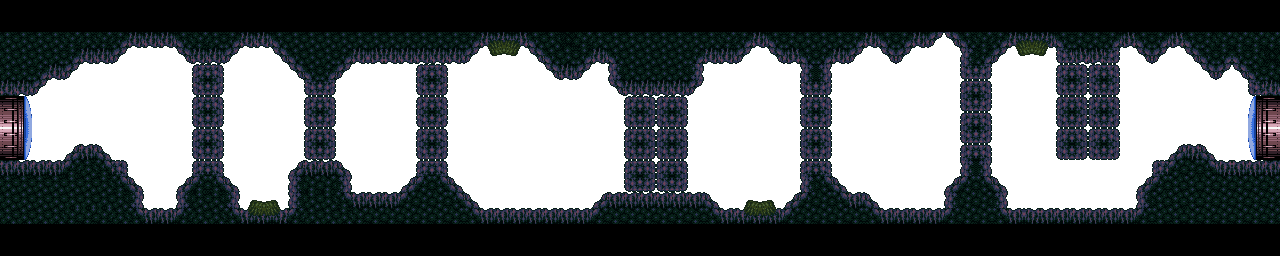

In [38]:
level_image("test.png", level, sce_tiles, cre_tiles)

In [39]:
#TODO: use y-flip and x-flip instead of v-flip and h-flip